In [152]:
# Import các thư viện cần dùng
# Để tính toán hiệu quả cho xử lý dữ liệu số
import numpy as np
# Để quản lý dữ liệu trong dataframe
import pandas as pd
# Để vẽ các loại biểu đồ
import matplotlib.pyplot as plt

# Import các mô hình hồi quy từ thư viện scikit-learn và các thư viện bổ sung
from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier
from sklearn.ensemble import GradientBoostingClassifier #Gradient Boosting Classifier
from sklearn.ensemble import HistGradientBoostingClassifier # Histogram Gradient Boosting Classifier
from xgboost import XGBClassifier  # XGBoost Classifier
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.tree import DecisionTreeClassifier #Decision Tree Classifier
from sklearn.svm import SVC #Support Vector Classification
from sklearn.neighbors import KNeighborsClassifier #K-Nearest Neighbors Classifier

# Import các hàm và lớp cần thiết cho việc chia dữ liệu và tìm siêu tham số
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

# Import các độ đo đánh giá mô hình hồi quy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Để tối ưu hoá và tìm kiếm siêu tham số
from scipy.stats import randint, uniform

## 1. Đọc dữ liệu

In [153]:
# Đọc tệp CSV vào DataFrame
df = pd.read_csv('Credit_risk_Processed.xls')

In [154]:
# Hiển thị vài dòng đầu tiên của DataFrame để xem nhanh về dữ liệu
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,0.013514,0.002751,0.121951,0.014493,0.321348,0.120482,0.000000,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0.067568,0.002751,0.024390,0.144928,0.418539,0.686747,0.035714,1,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0.040541,0.030209,0.097561,1.000000,0.551124,0.638554,0.000000,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.054054,0.024757,0.195122,1.000000,0.497191,0.662651,0.071429,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.013514,0.002898,0.048780,0.057971,0.096629,0.301205,0.000000,1,0,0,...,1,1,0,0,0,0,0,0,1,0


### 2. Train - Test Split

In [155]:
# Chia tập dữ liệu thành đặc trưng đầu vào và đầu ra
X = df.drop(columns='loan_status').values
y = df['loan_status'].values

In [156]:
# In ra kích thước 
print(f'Kích thước X: {X.shape}')
print(f'Kích thước y: {y.shape}')

Kích thước X: (32574, 26)
Kích thước y: (32574,)


In [157]:
# Chia dữ liệu thành tập train và test với tỷ lệ tập kiểm thử là 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Lựa chọn mô hình

In [158]:

def initialize_regression_models():
    """
    Khởi tạo các mô hình hồi quy.

    Returns:
    - dict, Dictionary chứa các mô hình hồi quy.
    """
    return {
        'Logistic Regression': LogisticRegression(max_iter=200),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'KNeighbors': KNeighborsClassifier(),
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Support Vector Machine': SVC(probability=True),
        'HistogramGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    }

def evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    """
    Huấn luyện mô hình và đánh giá hiệu suất.

    Parameters:
    - model_name: str, Tên mô hình.
    - model: object, Mô hình hồi quy.
    - X_train: DataFrame, Dữ liệu huấn luyện.
    - y_train: Series, Nhãn huấn luyện.
    - X_test: DataFrame, Dữ liệu kiểm thử.
    - y_test: Series, Nhãn kiểm thử.

    Returns:
    - dict, Dictionary chứa kết quả hiệu suất của mô hình.
    """
    # Huấn luyện mô hình với dữ liệu huấn luyện
    model.fit(X_train, y_train)
    # Dự đoán nhãn cho dữ liệu kiểm thử
    y_pred = model.predict(X_test)

    return {
        'Mô hình': model_name, # Tên mô hình
        'Accuracy': accuracy_score(y_test, y_pred), # Tính độ chính xác
        'Precision': precision_score(y_test, y_pred), # Tính độ chính xác của nhãn dương
        'Recall': recall_score(y_test, y_pred), # Tính độ nhạy
        'F1': f1_score(y_test, y_pred) # Tính điểm F1
    }

def run_all_models(X_train, y_train, X_test, y_test):
    """
    Huấn luyện và đánh giá tất cả các mô hình hồi quy.

    Parameters:
    - X_train: DataFrame, Dữ liệu huấn luyện.
    - y_train: Series, Nhãn huấn luyện.
    - X_test: DataFrame, Dữ liệu kiểm thử.
    - y_test: Series, Nhãn kiểm thử.

    Returns:
    - DataFrame, DataFrame chứa kết quả hiệu suất của tất cả các mô hình.
    """
    # Khởi tạo các mô hình hồi quy
    models = initialize_regression_models()
    # Danh sách để lưu trữ kết quả
    results = []

    for model_name, model in models.items():
        # Đánh giá từng mô hình
        result = evaluate_model(model_name, model, X_train, y_train, X_test, y_test)
        # Thêm kết quả vào danh sách
        results.append(result)

    # Chuyển đổi danh sách kết quả thành DataFrame
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

In [159]:
# Chạy hàm run_all_models và lưu kết quả vào DataFrame.
results_df = run_all_models(X_train, y_train, X_test, y_test)
# Xem kết quả đánh giá
results_df

,Mô hình,Accuracy,Precision,Recall,F1
0,HistogramGradientBoosting,0.937836,0.975541,0.732345,0.836628
1,XGBoost,0.936915,0.947462,0.751412,0.838125
2,Random Forest,0.934612,0.960037,0.729520,0.829053
3,Gradient Boosting,0.930775,0.953904,0.716102,0.818072
4,Support Vector Machine,0.899156,0.884498,0.616525,0.726592
5,DecisionTree,0.892249,0.741870,0.773305,0.757261
6,KNeighbors,0.889025,0.838710,0.605932,0.703567
7,Logistic Regression,0.864927,0.762231,0.550141,0.639048


Dựa trên kết quả tìm được, ta có thể thấy rằng mô hình `HistogramGradientBoosting` cho ra giá trị của các độ đo Accuracy, Precision, Recall, F1 là cao nhất. Do đó, đây là mô hình tối ưu nhất cho bộ dữ liệu tìm được.

## 4. Chạy mô hình HistogramGradientBoosting với tham số mặc định

In [160]:
# Tạo một HistGradientBoostingClassifier với các tham số mặc định
hgb_classifier = HistGradientBoostingClassifier()

# Xem các tham số mặc định
default_params = hgb_classifier.get_params()

# Chọn ra các tham số quan trọng
desired_params = ['max_iter', 'max_leaf_nodes', 'min_samples_leaf', 'max_depth', 'learning_rate', 'l2_regularization']

# Lọc các tham số quan trọng từ tham số mặc định
selected_default_params = {param: default_params[param] for param in desired_params}

# Tạo DataFrame từ các tham số quan trọng
default_params_df = pd.DataFrame([selected_default_params])

# Đảo ngược vị trí giữa tên tham số và giá trị
default_params_df = default_params_df.transpose()

# Đặt tên cột cho DataFrame
default_params_df.columns = ['Value']

# In ra DataFrame với tên tham số ở các dòng
print("Các tham số mặc định của HistGradientBoostingClassifier:")
default_params_df

Các tham số mặc định của HistGradientBoostingClassifier:


,Value
max_iter,100
max_leaf_nodes,31
min_samples_leaf,20
max_depth,None
learning_rate,0.1
l2_regularization,0.0


In [161]:
# Tạo một HistGradientBoostingClassifier với các tham số mặc định
hgb_classifier = HistGradientBoostingClassifier()

# Huấn luyện HistGradientBoostingClassifier trên dữ liệu huấn luyện
# và đưa ra dự đoán trên dữ liệu kiểm thử
hgb_classifier.fit(X_train, y_train)
y_pred = hgb_classifier.predict(X_test)

# In các độ đo đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred),
precision = precision_score(y_test, y_pred),
recall = recall_score(y_test, y_pred),
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: (0.9372217958557175,)
Precision: (0.9754485363550519,)
Recall: (0.7295197740112994,)
F1: 0.8347474747474747


## 5. Tuning cho HistGradientBoostingClassifier

In [162]:
# Khởi tạo mô hình Histogram Gradient Boosting
model = HistGradientBoostingClassifier()

# Định nghĩa các tham số để tìm kiếm
param_distributions = {
    'max_iter': randint(50, 200),             # Số lượng cây
    'max_leaf_nodes': randint(10, 50),        # Số lượng lá tối đa
    'min_samples_leaf': randint(1, 20),       # Số mẫu tối thiểu trong một lá
    'max_depth': randint(3, 10),              # Độ sâu tối đa của cây
    'learning_rate': uniform(0.01, 0.3),      # Tốc độ học
    'l2_regularization': uniform(0.0, 10.0)    # Hệ số điều chỉnh L2
}

# Khởi tạo RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=100,               # Số lần thử nghiệm
    cv=5,                     # Số lần k-fold cross-validation
    scoring='accuracy',       # Đánh giá dựa trên độ chính xác
    random_state=42,
    n_jobs=-1                 # Sử dụng tất cả các CPU có sẵn
)

# Huấn luyện với RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1b0eed790>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1b075d650>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1b0ebafd0>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1b0745250>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1b0eba510>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1b0ebaa90>},
                   random_state=42, scoring='accuracy')

In [163]:
# In điểm số tốt nhất và các tham số tốt nhất
# khi Random Search với các tham số trên
print(f'Điểm số tốt nhất: {random_search.best_score_:.3f}')

# Tạo DataFrame từ các tham số tốt nhất
best_params_df = pd.DataFrame([random_search.best_params_]).transpose()

# Đặt tên cột cho DataFrame
best_params_df.columns = ['Value']

# In ra DataFrame với tên tham số ở các dòng
print('Các tham số tốt nhất:')
best_params_df

Điểm số tốt nhất: 0.935
Các tham số tốt nhất:


,Value
l2_regularization,6.117207
learning_rate,0.135880
max_depth,6.000000
max_iter,193.000000
max_leaf_nodes,46.000000
min_samples_leaf,14.000000


## 6. Đánh giá mô hình với tham số tốt nhất

### 6.1 Train - Test Split

In [164]:
# Lấy tham số tốt nhất
best_params = random_search.best_params_

# Tạo một HistGradientBoostingClassifier với các tham số tốt nhất
best_model = HistGradientBoostingClassifier(**best_params, random_state=42)

# Huấn luyện lại mô hình với các tham số tốt nhất
best_model.fit(X_train, y_train)

# In các độ đo đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred),
precision = precision_score(y_test, y_pred),
recall = recall_score(y_test, y_pred),
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: (0.9372217958557175,)
Precision: (0.9754485363550519,)
Recall: (0.7295197740112994,)
F1: 0.8347474747474747


### 6.2 Cross Validation(K-Fold)

In [165]:
# Thiết lập K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Danh sách để lưu các giá trị accuracy, precisious, recall và f1 cho từng fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

# Vòng lặp qua các fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {i + 1}:')  # Đánh số fold từ 1 để hiển thị
    
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Huấn luyện mô hình trên tập huấn luyện của fold hiện tại
    best_model.fit(X_train_fold, y_train_fold)
    
    # Dự đoán trên tập kiểm tra của fold hiện tại
    y_pred_fold = best_model.predict(X_test_fold)

    # Tính toán các độ đo
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold)
    recall = recall_score(y_test_fold, y_pred_fold)
    f1 = f1_score(y_test_fold, y_pred_fold)

    # In các độ đo cho fold hiện tại
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}\n")

    # Lưu các độ đo vào danh sách
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)

# Tính và in trung bình các chỉ số
print("Mean Accuracy:", np.mean(fold_accuracies))
print("Mean Precision:", np.mean(fold_precisions))
print("Mean Recall:", np.mean(fold_recalls))
print("Mean F1 Score:", np.mean(fold_f1s))

Fold 1:
Accuracy: 0.938142747505756
Precision: 0.9668202764976959
Recall: 0.740819209039548
F1: 0.8388644542183127

Fold 2:
Accuracy: 0.938296239447429
Precision: 0.9630655586334257
Recall: 0.7423487544483985
F1: 0.8384244372990354

Fold 3:
Accuracy: 0.930775134305449
Precision: 0.9716713881019831
Recall: 0.7096551724137931
F1: 0.8202471104025508

Fold 4:
Accuracy: 0.9330775134305449
Precision: 0.9660056657223796
Recall: 0.71890372452565
F1: 0.8243352135374696

Fold 5:
Accuracy: 0.9365980964077372
Precision: 0.9734848484848485
Recall: 0.7275300778485492
F1: 0.8327257999189955

Mean Accuracy: 0.9353779462193831
Mean Precision: 0.9682095474880665
Mean Recall: 0.7278513876551878
Mean F1 Score: 0.8309194030752728


### 6.3 Visualization

In [166]:
def plot_metric_scores(metric_values, metric_name):
    """
    Vẽ biểu đồ cột cho các giá trị của một độ đo cụ thể.

    Parameters:
    - metric_values: Danh sách chứa giá trị của độ đo cho từng fold.
    - metric_name: Tên của độ đo (vd: 'Accuracy', 'Precision', 'Recall', 'F1').

    Returns:
    None.
    """
    
    # Tạo biểu đồ cột với metric_values
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(metric_values) + 1), metric_values, color='skyblue')
    
    # Đặt nhãn cho trục x và y
    plt.xlabel('Fold')
    plt.ylabel(f'Điểm {metric_name}')
    
    # Đặt tiêu đề cho biểu đồ
    plt.title(f'Điểm {metric_name} cho từng Fold')
    
    # Đặt các nhãn trục x là số fold
    plt.xticks(range(1, len(metric_values) + 1))

    # Thiết lập giới hạn cho trục y từ 0 đến 1 với bước là 0.1
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))  # Đặt các nhãn y từ 0 đến 1 với bước 0.1

    # Thêm lưới theo chiều ngang
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Hiển thị biểu đồ
    plt.show()

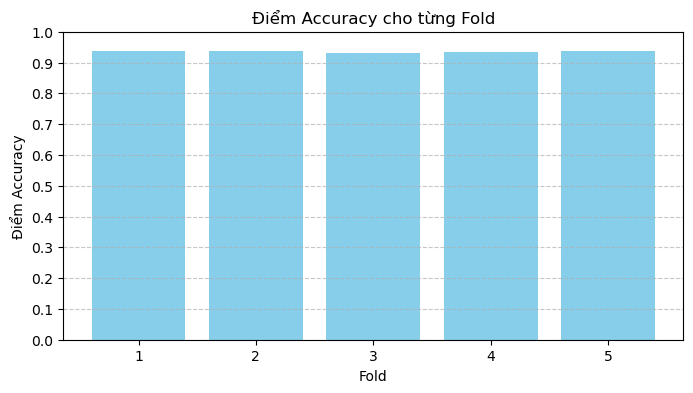

In [167]:
# Vẽ biểu đồ cho các giá trị Accuracy
plot_metric_scores(fold_accuracies, "Accuracy")

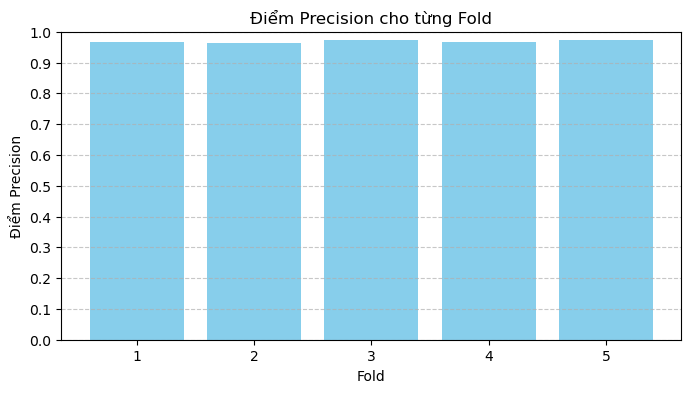

In [168]:
# Vẽ biểu đồ cho các giá trị Precision
plot_metric_scores(fold_precisions, "Precision")

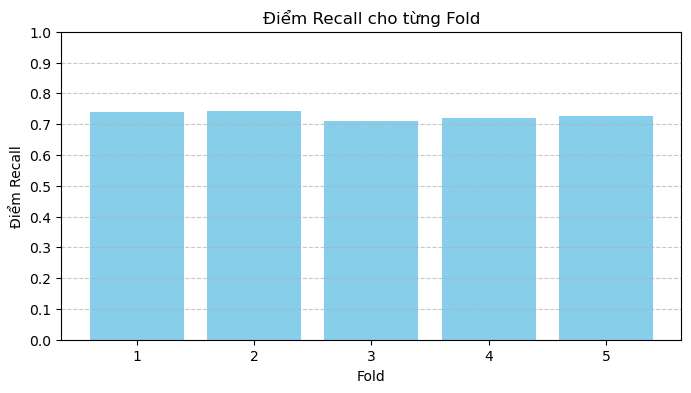

In [169]:
# Vẽ biểu đồ cho các giá trị Recall
plot_metric_scores(fold_recalls, "Recall")

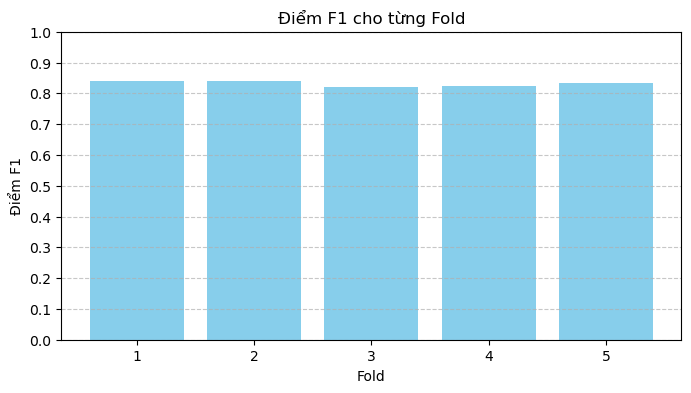

In [170]:
# Vẽ biểu đồ cho các giá trị F1
plot_metric_scores(fold_f1s, "F1")

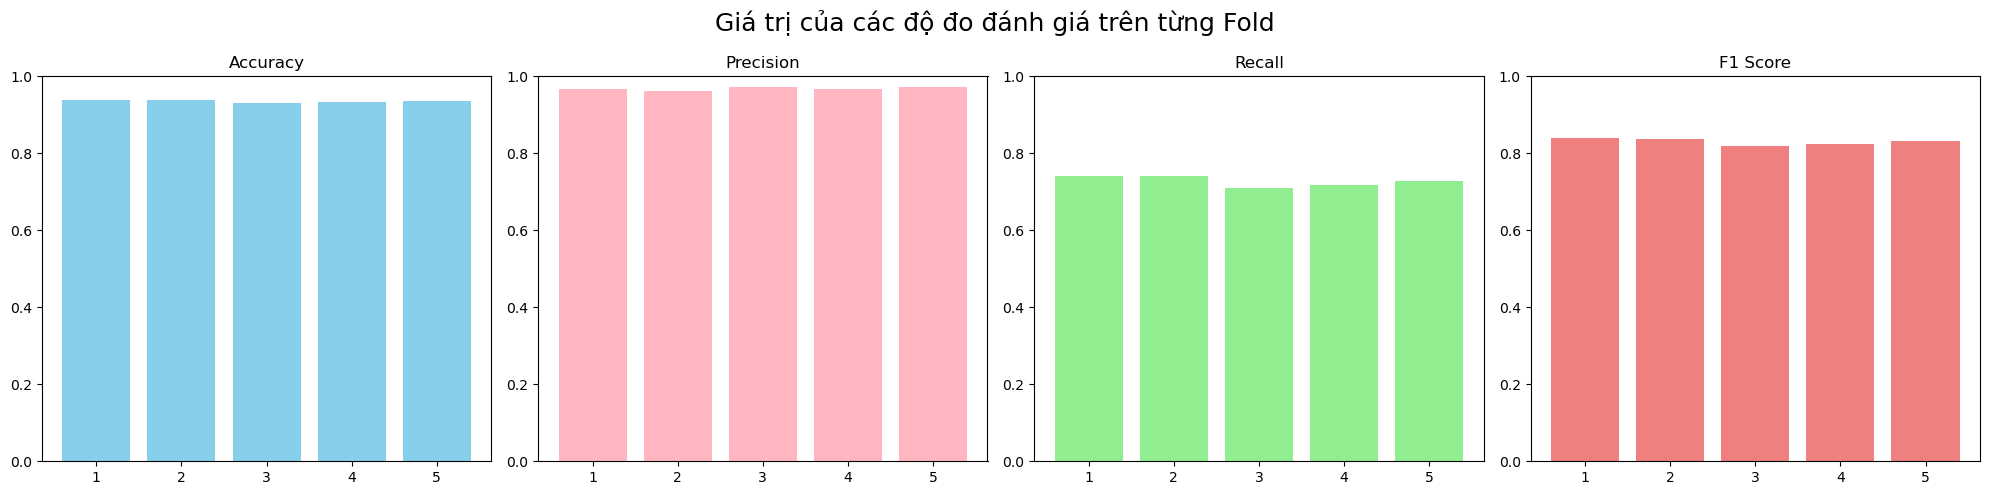

In [175]:
# Tạo figure và axes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

# Biểu đồ cho Accuracy
axes[0].bar(range(1, len(fold_accuracies) + 1), fold_accuracies, color='skyblue')
axes[0].set_title('Accuracy')
axes[0].set_ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
axes[0].set_xticks(range(1, len(fold_accuracies) + 1))

# Biểu đồ cho Precision
axes[1].bar(range(1, len(fold_precisions) + 1), fold_precisions, color='lightpink')
axes[1].set_title('Precision')
axes[1].set_ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
axes[1].set_xticks(range(1, len(fold_precisions) + 1))

# Biểu đồ cho Recall
axes[2].bar(range(1, len(fold_recalls) + 1), fold_recalls, color='lightgreen')
axes[2].set_title('Recall')
axes[2].set_ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
axes[2].set_xticks(range(1, len(fold_recalls) + 1))

# Biểu đồ cho F1 Score
axes[3].bar(range(1, len(fold_f1s) + 1), fold_f1s, color='lightcoral')
axes[3].set_title('F1 Score')
axes[3].set_ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
axes[3].set_xticks(range(1, len(fold_f1s) + 1))

# Tiêu đề chung cho cả 4 biểu đồ
fig.suptitle("Giá trị của các độ đo đánh giá trên từng Fold", fontsize=18)

# Hiển thị 4 biểu đồ cột trên cùng một hàng
plt.tight_layout()
plt.show()

Các biểu đồ này cho thấy rằng mô hình hoạt động tốt và ổn định qua các fold, với các chỉ số đánh giá đều ở mức cao. 